# Update Rule

In [11]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### Config

In [30]:
# Experimental setup arguments

class args:

    alpha = 0.2
    delta = 0.1
    epsilon = 0.2  # move it is movement in model output (rather than input) and much larger than before
    N = 1000  # number of samples in cohort (1000 vs. 10,000)
    C = 10  # constant uniform bound

### Model

In [13]:
from data_prep import load_data

path_to_csv_file = './data/cs-training.csv'
X_all, Y_all, data = load_data(path_to_csv_file)

n_training = 3000
X_train, X_rest, Y_train, Y_rest = train_test_split(X_all, Y_all, train_size=n_training, random_state=42)

d = X_all.shape[1] - 1
print('d=',d)

del X_all, Y_all

X_cv, Y_cv = X_rest, Y_rest

d= 10


In [14]:
# strategic feature indices
strat_features = np.array([1, 6, 8]) - 1 # for later

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

# # zero out non-strategic features
# assert model.coef_.shape == (1, d+1) 
# strat_coef = np.zeros((1, d+1))
# strat_coef[0, strat_features] = model.coef_[0, strat_features]

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


In [15]:
def train_logistic_regression(X, Y, **kwargs):
    # fit_intercept=False since X already has bias term
    model = LogisticRegression(fit_intercept=False, **kwargs)  # intercept pre-built in X
    model.fit(X, Y)
    assert model.classes_[0] == 0 and model.classes_[1] == 1
    return model

In [16]:
model = train_logistic_regression(X_train, Y_train)
# example_thresh = 0.5
# Y_proba = model.predict_proba(X_train)[:,1]
# Y_pred = Y_proba > example_thresh
print(model.coef_)

[[-0.18757267 -0.30846282  1.99498043 -0.11616463 -0.43657128  0.00442053
   1.62973726  0.14887474  0.14908201  0.02740456 -0.35073374]]


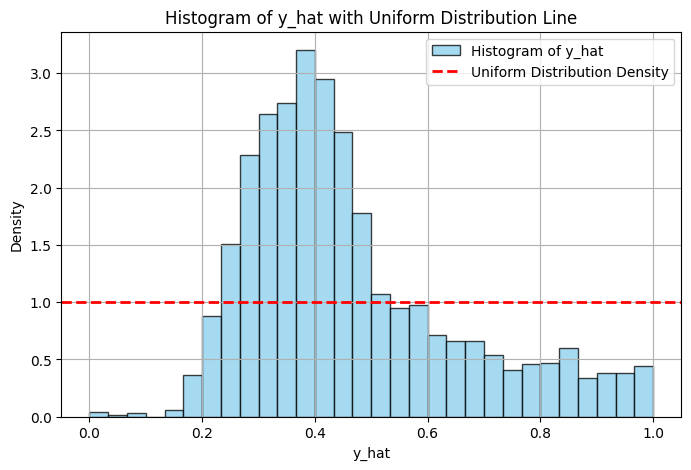

In [17]:
Y_hat = model.predict_proba(X_train)[:,1]



import matplotlib.pyplot as plt

# Assuming y_hat is already defined and contains values between 0 and 1
# Example: y_hat = np.random.uniform(0, 1, N)

plt.figure(figsize=(8, 5))

# Plot histogram of y_hat
counts, bins, _ = plt.hist(Y_hat, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.75, label='Histogram of y_hat')

# Overlay horizontal line for uniform distribution
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Uniform Distribution Density')

# Labels and legend
plt.xlabel('y_hat')
plt.ylabel('Density')
plt.title('Histogram of y_hat with Uniform Distribution Line')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


# Experiment

In [181]:
def type_II_error(Y, Y_proba, threshold):
    """Y=actual, Y_proba=predicted probability, threshold=threshold"""
    return np.mean((Y == 1) * (Y_proba < 1. - threshold))


def modify(Y_proba, threshold):
    in_move_range = np.logical_and(1 - threshold <= Y_proba, Y_proba <= 1 - threshold + args.epsilon)
    Y_proba_new = Y_proba.copy()
    Y_proba_new[in_move_range] -= args.epsilon
    return Y_proba_new

Text(0.5, 1.0, '$\\hat{y}$ before and after deployment of $\\lambda=0.3$')

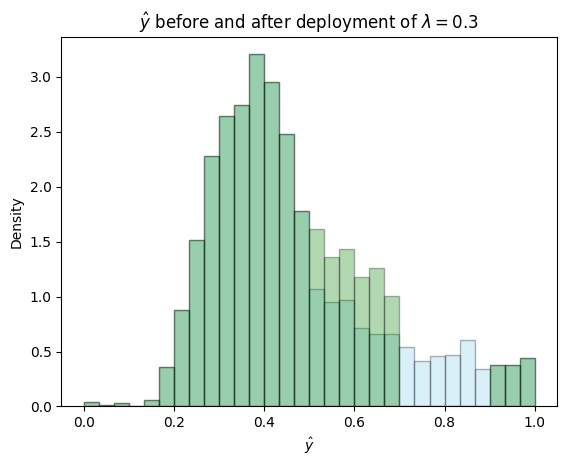

In [183]:
Y_proba = model.predict_proba(X_train)[:,1]
Y_proba_moved = modify(Y_proba, 0.3)

counts, bins, _ = plt.hist(Y_proba, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.3, label='Histogram of y_hat')
counts, bins, _ = plt.hist(Y_proba_moved, bins=30, density=True, color='green', edgecolor='black', alpha=0.3, label='Histogram of moved y_hat')
plt.ylabel('Density')
plt.xlabel(r'$\hat{y}$')
plt.title(r'$\hat{y}$ before and after deployment of $\lambda=0.3$')

In [184]:
def secant_solver(objective, lam0, lam1, tol=1e-6, max_iter=100):
    f0 = objective(lam0)
    f1 = objective(lam1)
    print(f"lam0: {lam0}, lam1: {lam1}, f0: {f0}, f1: {f1}")
    for _ in range(max_iter):
        if abs(f1) < tol:
            return lam1
        # Update using the secant method formula.
        lam_new = lam1 - f1 * (lam1 - lam0) / (f1 - f0)
        lam0, f0 = lam1, f1
        lam1 = lam_new
        f1 = objective(lam1)
    return lam1



def binary_search_solver(objective, lam_low, lam_high, tol=1e-6, max_iter=100):
    if objective(lam_low) <= 0:
        return lam_low
    
    if objective(lam_high) > 0:
        raise ValueError("No crossing found: objective > 0 for all λ in [lam_low, lam_high].")

    for _ in range(max_iter):
        mid = (lam_low + lam_high) / 2.0
        if objective(mid) <= 0:
            lam_high = mid
        else:
            lam_low = mid
        if lam_high - lam_low < tol:
            break
    return lam_high

In [185]:
np.sqrt(np.log(2/args.delta*5) / args.N)

np.float64(0.06786140424415112)

In [206]:
def run_trajectory(Y_all, Y_hat_all, lam_init = 1., num_iters: int = 1):

    lam = lam_init  # lambda^{(0)}
    B = np.sqrt(np.log(2/args.delta*num_iters) / args.N)

    lam_naives = [1.0]
    lam_awares = [1.0]
    lams = [lam_init]

    for t in range(1, num_iters + 1):

        # Draw N random samples, possibly repeating from Y_all and Y_hat_all
        idx = np.random.choice(len(Y_all), args.N, replace=True)
        Y = Y_all[idx]
        Y_hat = Y_hat_all[idx]

        # Individuals shift
        Y_hat_t = modify(Y_hat, lam)

        try:
            obj_naive = lambda lam_new: type_II_error(Y, Y_hat_t, lam_new) + B - args.alpha
            lam_naive = args.epsilon + binary_search_solver(obj_naive, 0.0, 1.0)
        except ValueError:
            lam_naive = 1.0

        try:
            # Range is +/- 1 / C from prev automatically

            # Break down into two objectives b/c of absolute value

            # assume lam_new > lam
            try:
                obj_aware_pos = lambda lam_new: type_II_error(Y, Y_hat_t, lam_new) + B \
                    + args.C * (lam_new - lam) - args.alpha
                lam_aware_pos = binary_search_solver(obj_aware_pos, lam, lam + 1 / args.C)
            except ValueError:
                lam_aware_pos = 1.0

            try:
                obj_aware_neg = lambda lam_new: type_II_error(Y, Y_hat_t, lam_new) + B \
                    - args.C * (lam_new - lam) - args.alpha
                lam_aware_neg = binary_search_solver(obj_aware_neg, lam - 1 / args.C, lam)
            except ValueError:
                lam_aware_neg = 1.0
            
            lam_aware = min(lam_aware_pos, lam_aware_neg)
        except ValueError:
            lam_aware = 1.0
        
        lam = min(lam, lam_naive, lam_aware)

        # Update lambda
        lam_naives.append(lam_naive)
        lam_awares.append(lam_aware)
        lams.append(lam)
    return lam, lam_naives, lam_awares, lams

### Run

In [207]:
args.alpha = 0.2
Y_proba = model.predict_proba(X_cv)[:,1]
Y = Y_cv
lam, lams_naive, lams_aware, lams = run_trajectory(Y, Y_proba, lam_init = 1.0, num_iters=100)

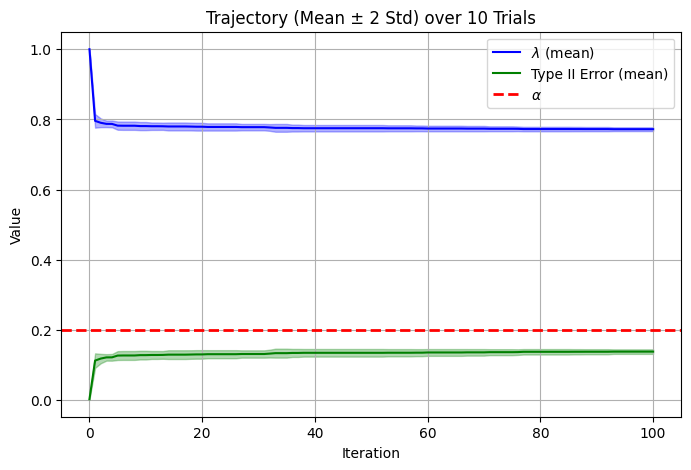

In [209]:
import numpy as np
import matplotlib.pyplot as plt

# Number of trials
num_trials = 10
num_iters = 100

# Containers for trajectories and type II error trajectories
all_lams = []          # To store lambda trajectories (each of length num_iters)
all_typeII = []        # To store type II error trajectories (each of length num_iters)

for trial in range(num_trials):
    # Run a single trial (assumes run_trajectory, type_II_error, and modify are defined)
    lam, lams_naive, lams_aware, lams = run_trajectory(Y, Y_proba, lam_init=1.0, num_iters=num_iters)
    
    # Record the lambda trajectory
    all_lams.append(lams)
    
    # Compute type II error at each iteration
    typeII_errors = [type_II_error(Y, modify(Y_proba, lam_val), lam_val) for lam_val in lams]
    all_typeII.append(typeII_errors)

# Convert lists to numpy arrays for easier computation
all_lams = np.array(all_lams)         # shape: (num_trials, num_iters)
all_typeII = np.array(all_typeII)       # shape: (num_trials, num_iters)

# Compute mean and standard deviation across trials for each iteration
mean_lams = np.mean(all_lams, axis=0)
std_lams = np.std(all_lams, axis=0)
mean_typeII = np.mean(all_typeII, axis=0)
std_typeII = np.std(all_typeII, axis=0)

# Prepare x-axis as iteration indices
iterations = np.arange(1 + num_iters)

# Plot the mean trajectories with standard deviation shading
plt.figure(figsize=(8, 5))

# Plot lambda trajectory
plt.plot(iterations, mean_lams, label=r'$\lambda$ (mean)', color='blue')
plt.fill_between(iterations, mean_lams - 2 * std_lams, mean_lams + 2 * std_lams, 
                 color='blue', alpha=0.3)

# Plot type II error trajectory
plt.plot(iterations, mean_typeII, label='Type II Error (mean)', color='green')
plt.fill_between(iterations, mean_typeII - 2 * std_typeII, mean_typeII + 2 * std_typeII, 
                 color='green', alpha=0.3)

# Plot horizontal line for alpha (assumes args.alpha is defined)
plt.axhline(y=args.alpha, color='red', linestyle='--', linewidth=2, label=r'$\alpha$')

plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trajectory (Mean ± 2 Std) over {} Trials'.format(num_trials))
plt.legend()
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y')
plt.show()


In [203]:
last_lambda = mean_lams[-1]
type_II_error(Y, modify(Y_proba, last_lambda), last_lambda)

np.float64(0.17549000455818195)

In [205]:
args.alpha

0.2

In [204]:
last_lambda

np.float64(0.7404538154602052)